In [1]:
library(tidyverse)
library(networkD3)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Constants

In [2]:
# Read in root data directory
con <- file("../dev_paths.txt", "r")
data_dir <- readLines(con,n=1)
close(con)

dsets <- c("unified_cervical_data")
dset_paths <- unlist(map(dsets, function(d) paste0(data_dir, "/", d)))
analysis_dir <- paste(data_dir, "analysis", sep = "/")
figures_dir <- paste(data_dir, "figures", sep = "/")
matrisome_list <- paste(data_dir, "matrisome", "matrisome_hs_masterlist.tsv", sep = "/")
dset_idx <- 1

## Functions

In [142]:
to_vplot_df <- function(df) {
    vplot_df <- df %>%
        dplyr::rename(log2_fc = log2FoldChange) %>%
        dplyr::rename(gene_ID = geneID) %>%
        dplyr::rename(base_mean = baseMean) %>%
        dplyr::mutate(neg_log10_padj = -log10(padj)) %>%
        dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_padj, padj, pvalue)
    return(vplot_df)
}


make_vplot <- function(df, add_contour = FALSE, jitter_w = 0, jitter_h = 0) {
    plt <- ggplot(df) +
        aes(y = neg_log10_padj, x = log2_fc) +
        geom_point(size = 1, position = position_jitter(w = jitter_w, h = jitter_h)) +
        {if (add_contour) geom_density2d(aes(colour=..level..))} +
        {if (add_contour) scale_colour_gradient(low = "#00e600", high="#cc0000", name = "Density")} +
        geom_hline(yintercept = -log10(0.05), linetype = "longdash", colour = "#737373", size = 0.5) +
        geom_vline(xintercept = log2(2), linetype = "longdash", colour = "#BE684D", size = 0.5) +
        geom_vline(xintercept = -1, linetype = "longdash", colour = "#2C467A", size = 0.5) +
        labs(title = "Matrisome DEG Analysis",
            subtitle = "CESC") +
        xlab("log2 fold-change") +
        ylab("-log10(adj. p-val)") +
        guides(alpha="none")

    return(plt)
}

## Load data

In [143]:
dge_matrisome_rj_df <- read_tsv(paste(analysis_dir, "unified_cervical_data_all_matrisome_xref_unified_data.tsv", sep = "/"))
all_genes_df <- read_tsv(paste(analysis_dir, "unified_cervical_data_unfiltered_DESeq_results.tsv", sep = "/"))

Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  in_unified_dataset = col_logical(),
  division = col_character(),
  category = col_character(),
  gene_name = col_character(),
  synonyms = col_character(),
  hgnc_ids = col_double(),
  hgnc_ids_links = col_double(),
  uniprot_ids = col_character(),
  refseq_ids = col_character(),
  orthology = col_character(),
  notes = col_character()
)
Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double()
)


In [144]:
# vplot_df <- dge_matrisome_rj_df %>%
#     dplyr::rename(log2_fc = log2FoldChange) %>%
#     dplyr::rename(gene_ID = geneID) %>%
#     dplyr::rename(base_mean = baseMean) %>%
#     dplyr::mutate(neg_log10_padj = -log10(padj)) %>%
#     dplyr::filter(in_unified_dataset == TRUE) %>%
#     dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_padj, padj, pvalue)
vplot_df <- to_vplot_df(dge_matrisome_rj_df)
head(vplot_df)

# all_genes_vplot_df <- to_vplot_df(all_genes_df)

gene_ID,base_mean,log2_fc,neg_log10_padj,padj,pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PGF,1439.047628,1.7961389,0.620706562,0.239493338,0.0951010364
TIMP4,49.579600,-2.5000604,0.582347926,0.261608635,0.1075551535
C1QTNF6,1663.611171,0.8317585,0.263796789,0.544757491,0.3190224832
TNC,14887.584519,0.1505524,0.005103965,0.988316476,0.8976652543
PRL,4.336559,-4.5906659,0.807584679,0.155745433,0.0519566391
OGN,586.195062,-7.1447904,2.795436023,0.001601637,0.0001612998


In [145]:
padj_na_mask <- is.na(vplot_df$padj)
vplot_df[padj_na_mask, ]

gene_ID,base_mean,log2_fc,neg_log10_padj,padj,pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BSPH1,0,NA,NA,NA,NA
S100A7L2,0,NA,NA,NA,NA
LGALS16,0,NA,NA,NA,NA
KCP,NA,NA,NA,NA,NA
SPON1,NA,NA,NA,NA,NA
SSPO,NA,NA,NA,NA,NA
COL26A1,NA,NA,NA,NA,NA
GRIFIN,NA,NA,NA,NA,NA
HSPC159,NA,NA,NA,NA,NA


## Volcano plots

Warning message:
“Removed 22 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 22 rows containing missing values (geom_point).”

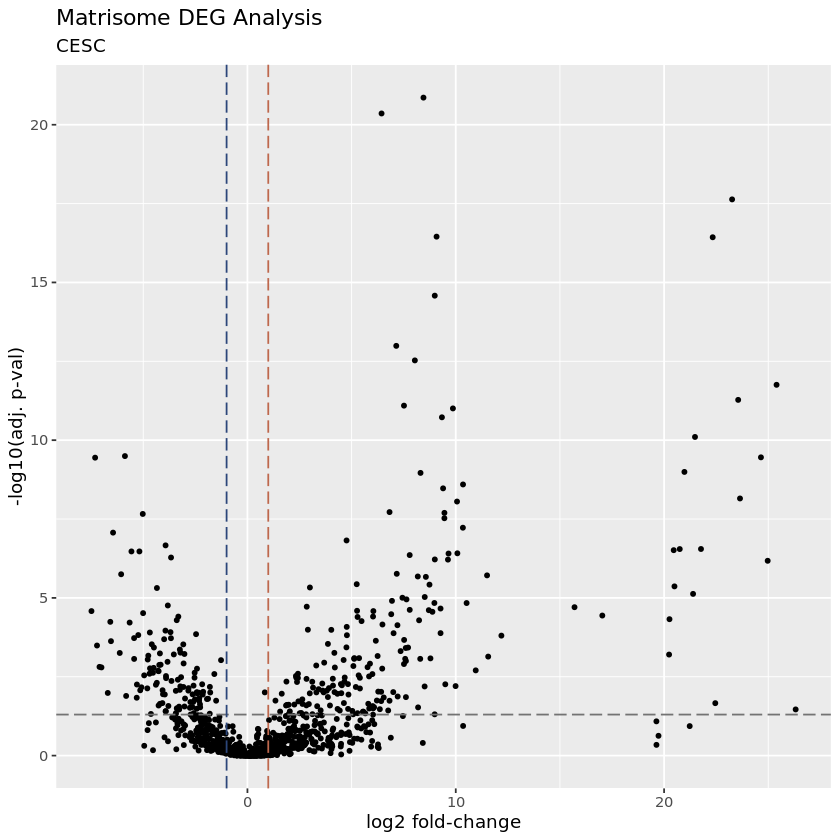

In [146]:
make_vplot(vplot_df, jitter_h = 0, jitter_w = 0.3)
ggsave(paste(figures_dir, "all_matrisome_vplot.png", sep = "/"), last_plot())

## Sankey diagram

In [147]:
sd_df <- dge_matrisome_rj_df %>%
    mutate(gene_list = rep("Matrisome genes", nrow(dge_matrisome_rj_df))) %>%
    mutate(in_dset = ifelse(in_unified_dataset, "In dataset", "Not in dataset")) %>%
    mutate(DEG_cat = ifelse(padj < 0.05, "DEGs", "Not DEGs")) %>%
    select(gene_list, in_dset, DEG_cat, category)
# Some genes are present in the dataset, but unexpressed in both conditions
present_unexpressed_mask <- sd_df$in_dset == "In dataset" & is.na(sd_df$DEG_cat)
sd_df[present_unexpressed_mask, ]$DEG_cat = "Not DEGs"
head(sd_df)

gene_list,in_dset,DEG_cat,category
<chr>,<chr>,<chr>,<chr>
Matrisome genes,In dataset,Not DEGs,Secreted Factors
Matrisome genes,In dataset,Not DEGs,ECM Regulators
Matrisome genes,In dataset,Not DEGs,ECM-affiliated Proteins
Matrisome genes,In dataset,Not DEGs,ECM Glycoproteins
Matrisome genes,In dataset,Not DEGs,Secreted Factors
Matrisome genes,In dataset,DEGs,Proteoglycans


In [148]:
source_v = c()
target_v = c()
value_v = c()

In [131]:
sd1_df <- sd_df %>%
    group_by(gene_list, in_dset) %>%
    summarize(n = n())
sd1_df

source_v <- c(source_v, sd1_df$gene_list)
target_v <- c(target_v, sd1_df$in_dset)
value_v <- c(value_v, sd1_df$n)

`summarise()` regrouping output by 'gene_list' (override with `.groups` argument)


gene_list,in_dset,n
<chr>,<chr>,<int>
Matrisome genes,In dataset,1008
Matrisome genes,Not in dataset,19


In [132]:
sd2_df <- sd_df %>%
    group_by(in_dset, DEG_cat) %>%
    filter (in_dset == "In dataset") %>%
    summarize(n = n())
sd2_df

source_v <- c(source_v, sd2_df$in_dset)
target_v <- c(target_v, sd2_df$DEG_cat)
value_v <- c(value_v, sd2_df$n)

`summarise()` regrouping output by 'in_dset' (override with `.groups` argument)


in_dset,DEG_cat,n
<chr>,<chr>,<int>
In dataset,DEGs,312
In dataset,Not DEGs,696


In [133]:
sd3_df <- sd_df %>%
    group_by(DEG_cat, category) %>%
    filter(DEG_cat == "DEGs") %>%
    summarize(n = n())
sd3_df

source_v <- c(source_v, sd3_df$DEG_cat)
target_v <- c(target_v, sd3_df$category)
value_v <- c(value_v, sd3_df$n)

`summarise()` regrouping output by 'DEG_cat' (override with `.groups` argument)


DEG_cat,category,n
<chr>,<chr>,<int>
DEGs,Collagens,8
DEGs,ECM Glycoproteins,56
DEGs,ECM Regulators,74
DEGs,ECM-affiliated Proteins,54
DEGs,Proteoglycans,10
DEGs,Secreted Factors,110


In [134]:
links_df <- tibble(
    source = source_v,
    target = target_v,
    value = value_v,
)

nodes_df <- tibble(
    name = c(links_df$source, links_df$target) %>% unique()
)

links_df$sourceID <- match(links_df$source, nodes_df$name) - 1
links_df$targetID <- match(links_df$target, nodes_df$name) - 1

In [135]:
links_df

source,target,value,sourceID,targetID
<chr>,<chr>,<int>,<dbl>,<dbl>
Matrisome genes,In dataset,1008,0,1
Matrisome genes,Not in dataset,19,0,3
In dataset,DEGs,312,1,2
In dataset,Not DEGs,696,1,4
DEGs,Collagens,8,2,5
DEGs,ECM Glycoproteins,56,2,6
DEGs,ECM Regulators,74,2,7
DEGs,ECM-affiliated Proteins,54,2,8
DEGs,Proteoglycans,10,2,9


In [136]:
nodes_df

name
<chr>
Matrisome genes
In dataset
DEGs
Not in dataset
Not DEGs
Collagens
ECM Glycoproteins
ECM Regulators
ECM-affiliated Proteins


In [138]:
sankeyNetwork(
    Links = links_df,
    Nodes = nodes_df,
    Source = "sourceID",
    Target = "targetID",
    Value = "value",
    NodeID = "name",
    fontSize = 16,
    fontFamily = "calibri",
    sinksRight=FALSE
)

Links is a tbl_df. Converting to a plain data frame.
Nodes is a tbl_df. Converting to a plain data frame.


HTML widgets cannot be represented in plain text (need html)